__собираем статистики по объявлениям о продаже домов__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пн 12 авг 2024 11:45:23 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_house.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

46012

title  \
114    двухэтажный дом на академической   
23899      дом 119 м² на участке 4 сот.   
19815      дом 110 м² на участке 4 сот.   

                                                                    address  \
114    севастополь,р-н гагаринский,мкр.стрелецкая бухта,улица академическая   
23899                                                  севастополь,тсн союз   
19815                     севастополь,садоводческое товарищество планер-2,2   

       latitude  longitude  priceM          dt  
114       44.60      33.47   40.00  2024-06-11  
23899     44.51      33.52    8.90  2024-06-13  
19815     44.53      33.46    9.98  2024-07-16

In [4]:
df.loc[df['address'].str.match(r'.*белогорск.*'),'place'] = 'belogorsk'
df.loc[df['address'].str.match(r'.*кировский.*'),'place'] = 'kirovsky'

---

In [5]:
# df_ = pd.read_pickle('data/2023/data_house.pkl').rename(columns={'adr':'address'})
# df_['dt'] = df_['ts'].dt.date
# display( len(df_) )
# display( df_.sample(3)[cols] )

In [6]:
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [7]:
# # history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

In [8]:
# df = pd.concat([df,df_]).reset_index(drop=True)
# display( len(df) )
# del df_

---

In [9]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

---

In [10]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

46012

46012

In [11]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

46012

32744

32694

In [12]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
29496    дом 145 м² на участке 6 сот.   
24441  дом 150 м² на участке 9,5 сот.   
28276    дом 114 м² на участке 6 сот.   

                                          address  latitude  longitude  \
29496    севастополь,тсн родник,ул.дмитрия зюзина     44.55      33.56   
24441  бахчисарай,с.железнодорожное,подгорная ул.     44.72      33.80   
28276  севастополь,тсн родник,ул.ивана ковальчука     44.54      33.56   

       priceM          dt  
29496   10.50  2024-06-10  
24441    4.00  2024-06-07  
28276   14.00  2024-07-08

---

---

In [13]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
print( dt_min, ' : ',dt_max )
# display( dt_min,history_date,dt_max )

2024-06-07  :  2024-08-12


In [14]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak','bahchisaray')")
    # .drop_duplicates(['dt','url'])
    .drop_duplicates(['url','week'])
    .reset_index(drop=True)
)
display( len(gdf) )

32694

21758

In [15]:
# gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

In [16]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [17]:
# display( len(gdf_history) )
# display( len(gdf) )

---

In [18]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [19]:
# gdf['place'].unique()

# общая статистика

In [20]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [21]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [22]:
# gdf[ gdf['address'].str.match(r'.*ялта.*') ]
# gdf[ gdf['address'].str.match(r'.*окуневка.*') ]
# gdf[ gdf['address'].str.match(r'.*заветное.*') ]

In [23]:
gdf.query('place=="bahchisaray"')[['title','address','priceM','geometry']].explore()

In [24]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [25]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        #gdf.groupby(['place','house_size_category','month'],observed=True)
        gdf.groupby(['place','house_size_category','week'],observed=True)
    
        ['priceM'].describe(percentiles=percentiles)
    )

# display( stat )

In [26]:
stat.reset_index()['house_size_category'].unique()

['30-50', '50-70', '70-110', '110-180', '180-300', '300+']
Categories (6, object): ['30-50' < '50-70' < '70-110' < '110-180' < '180-300' < '300+']

In [27]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
# sizes = stat.reset_index()['house_size_category'].unique()
sizes = ['50-70', '70-110','110-180', '180-300' ]
# sizes = ['50-70', '70-150','150-300' ]
display(sizes)

['50-70', '70-110', '110-180', '180-300']

In [28]:
# display(len(gdf))
# gdf_ = gdf[ gdf['house_size_category'].isin(sizes) ].reset_index()
# display(len(gdf_))
# gdf_[['title','house_size_category']]

In [29]:
# dt_now = pd.to_datetime('2024-06-17').date()
# dt_now = gdf['dt'].max()

In [30]:
# (
# gdf
# .query('house_size_category in @sizes')
# .drop_duplicates(['url'])
# .groupby(['house_size_category','place'],observed=True)['url'].count()
# .reset_index()
# .pivot(index='place', columns='house_size_category', values='url')
# .plot.barh(title='количество предложений') #,log=True)
# .grid(axis='x')    
# )

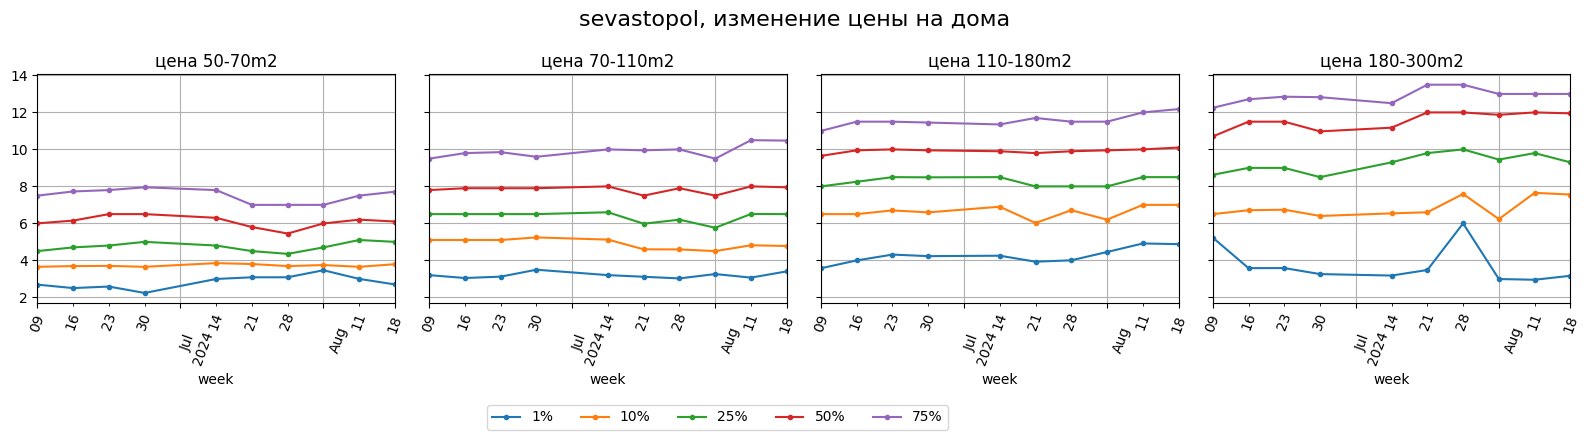

In [31]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

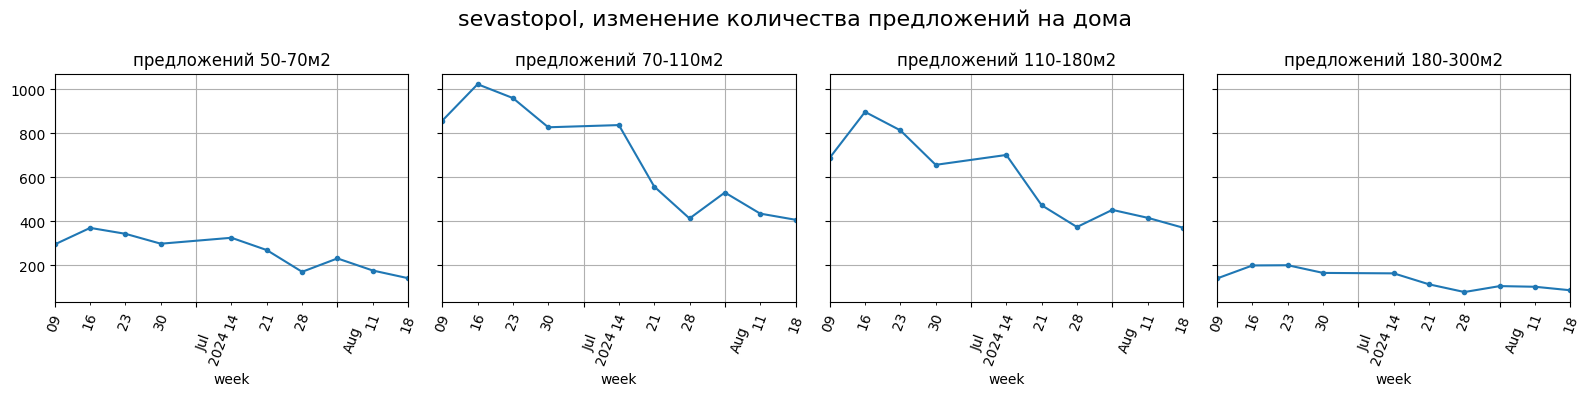

In [32]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение количества предложений на дома', fontsize=16)
fig.tight_layout()

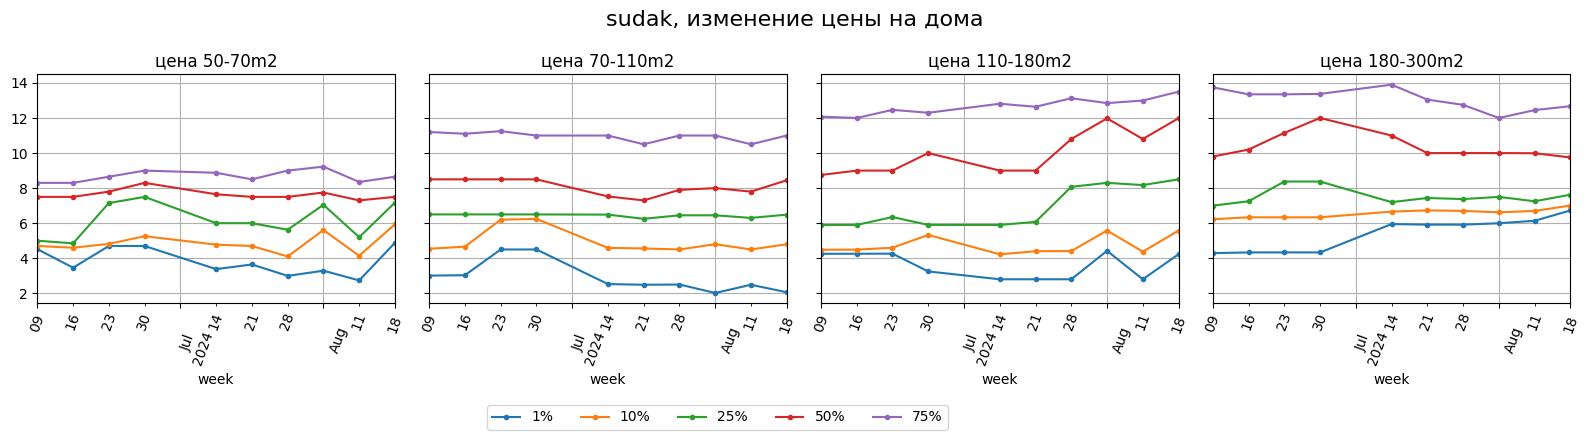

In [33]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

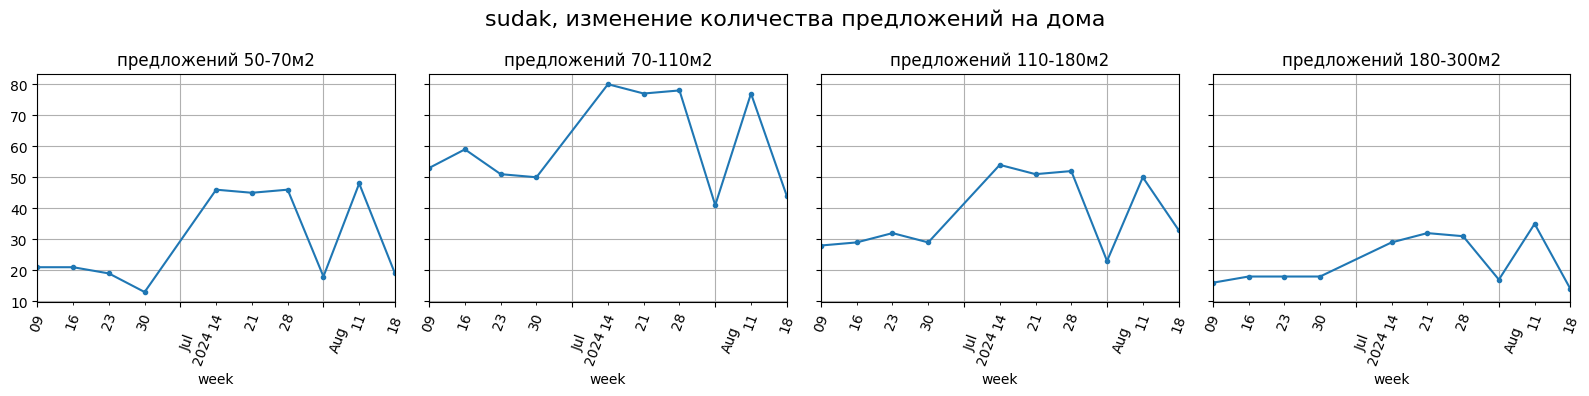

In [34]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение количества предложений на дома', fontsize=16)
fig.tight_layout()

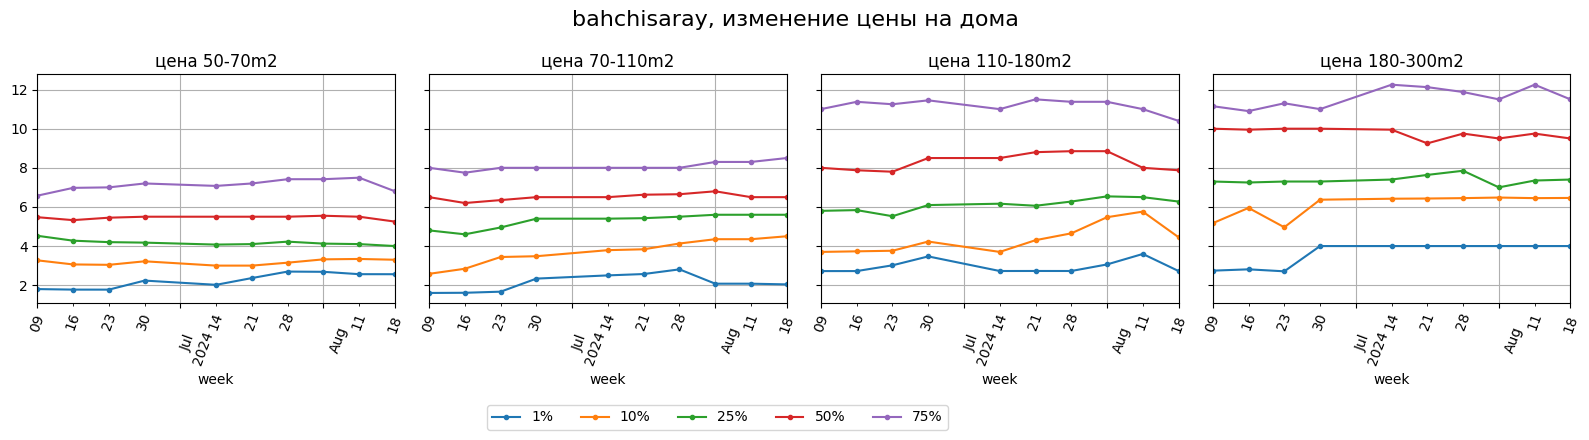

In [35]:
place = 'bahchisaray'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

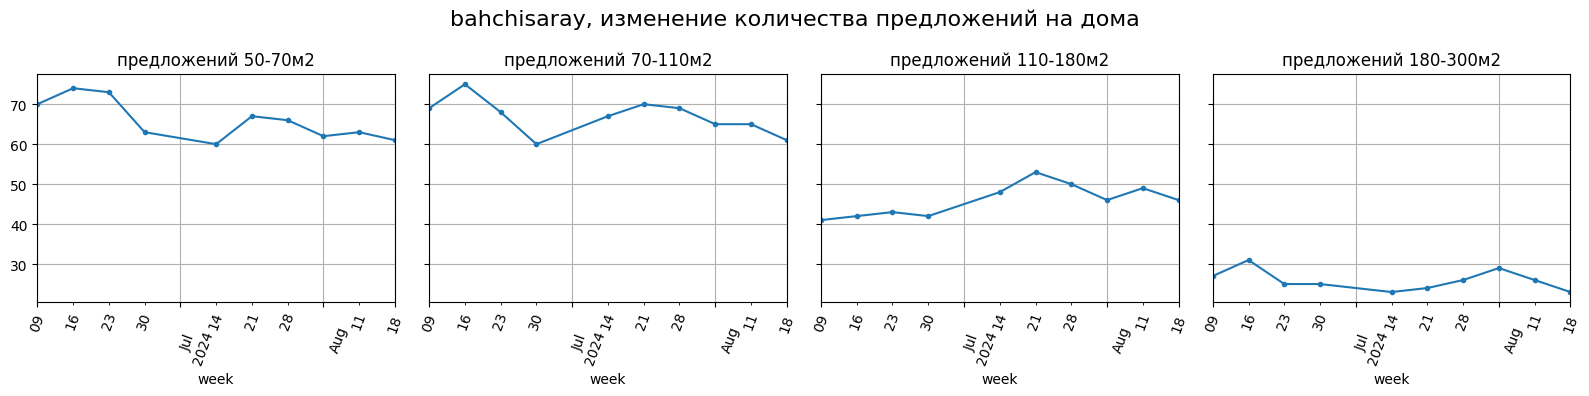

In [36]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение количества предложений на дома', fontsize=16)
fig.tight_layout()

# актуальная цена

In [37]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

21758

1414

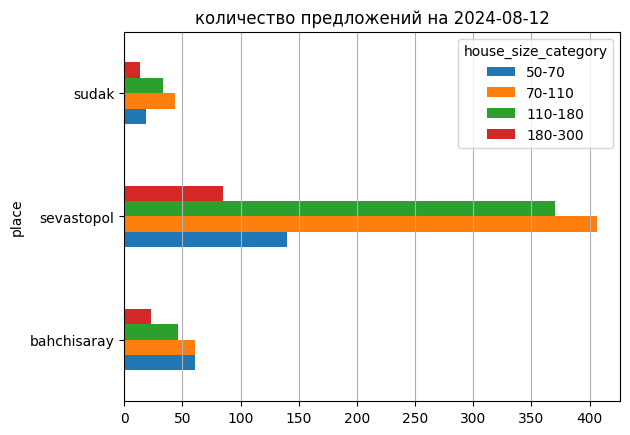

In [38]:
(
gdf_last
.query('house_size_category in @sizes')
.drop_duplicates(['url'])
.groupby(['house_size_category','place'],observed=True)['url'].count()
.reset_index()
.pivot(index='place', columns='house_size_category', values='url')
# .plot.barh(title='количество предложений') #,log=True)
.plot.barh(title='количество предложений на '+ str( dt_now ))
.grid(axis='x')    
)

In [39]:
(
    gdf_last
    .groupby(['place','house_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std   min    1%    5%   10%  \
place       house_size_category                                             
bahchisaray 30-50                28.00  4.24 1.72  2.00  2.06  2.25  2.30   
            50-70                61.00  5.58 1.89  2.50  2.56  3.00  3.30   
            70-110               61.00  7.30 2.92  1.50  2.04  3.30  4.50   
            110-180              46.00  8.34 3.06  2.70  2.72  3.55  4.45   
            180-300              23.00  9.42 2.88  4.00  4.00  4.25  6.46   
            300+                  5.00 13.00 1.87 10.00 10.12 10.60 11.20   
sevastopol  30-50                61.00  5.47 2.55  2.50  2.62  3.00  3.40   
            50-70               140.00  6.57 2.52  1.30  2.70  3.50  3.79   
            70-110              406.00  8.33 2.66  1.74  3.40  4.30  4.78   
            110-180             370.00 10.33 2.50  3.45  4.88  5.99  7.00   
            180-300              85.00 11.09 2.69  2.95  3.16  6.22  7.56   
            300+                  7.00 10.67 3.19  5.50  5.66  6.31  7.12   
sudak       30-50                 6.00  7.50 3.52  4.00  4.04  4.20  4.40   
            50-70                19.00  8.33 2.38  4.70  4.88  5.60  5.94   
            70-110               44.00  8.49 2.95  1.50  2.06  3.82  4.80   
            110-180              33.00 10.79 3.25  4.15  4.23  5.03  5.58   
            180-300              14.00 10.22 2.98  6.70  6.73  6.83  7.00   
            300+                  5.00  9.98 2.38  7.20  7.27  7.56  7.92   

                                  25%   50%   75%   90%   95%   max  
place       house_size_category                                      
bahchisaray 30-50                2.94  3.87  5.50  6.04  7.22  9.00  
            50-70                4.00  5.25  6.80  7.80  8.20 11.50  
            70-110               5.60  6.50  8.50 11.20 14.00 14.50  
            110-180              6.28  7.88 10.40 12.40 13.87 14.55  
            180-300              7.40  9.50 11.50 12.74 13.88 14.30  
            300+                13.00 13.00 14.00 14.59 14.79 14.99  
sevastopol  30-50                4.00  4.70  6.00  8.30 11.00 14.30  
            50-70                5.00  6.10  7.71  9.65 12.51 14.00  
            70-110               6.50  7.95 10.47 12.00 13.00 14.95  
            110-180              8.50 10.10 12.18 14.00 14.21 15.00  
            180-300              9.30 11.95 13.00 14.00 14.33 14.95  
            300+                 8.80 11.60 12.50 13.80 14.40 15.00  
sudak       30-50                5.35  7.25  7.65 10.85 12.43 14.00  
            50-70                7.18  7.50  8.65 12.10 12.60 13.50  
            70-110               6.49  8.45 11.00 12.51 12.98 13.50  
            110-180              8.50 11.99 13.50 13.96 14.78 14.90  
            180-300              7.62  9.75 12.68 14.38 14.61 14.80  
            300+                 9.00  9.20 11.00 12.50 13.00 13.50

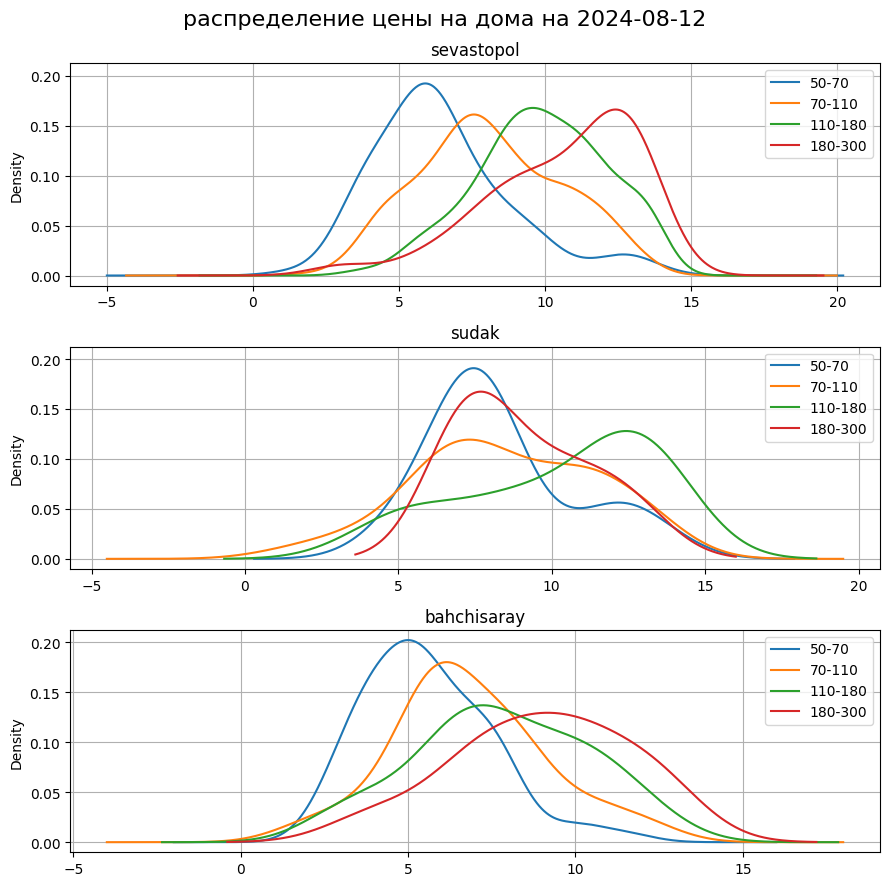

In [40]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
        .groupby(['house_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

In [41]:
# (
# gdf_last
# .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
# .groupby(['house_size_category'],observed=True)
# ['priceM'].plot.kde()
# )

# цены на карте

In [42]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [43]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [44]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [45]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [46]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [47]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [48]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [49]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [50]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [51]:
display(frames)

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5   Севастополь, кр.горка (старый)   
6    Севастополь, кр.горка (новый)   
7      Севастополь, Малахов курган   
8       Севастополь, Благополучный   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                          POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [52]:
frames.explore('area_name', legend=True)

In [53]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
'Севастополь, кр.горка (старый)',
'Севастополь, кр.горка (новый)',
'Севастополь, Благополучный',
]

In [54]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

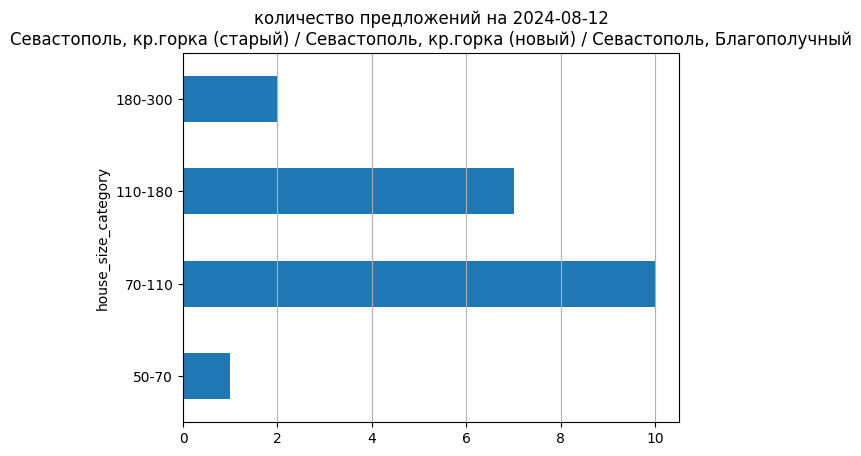

In [55]:
(
    gdf_last_local
    .drop_duplicates('url')
    .query('house_size_category in @sizes')
    .groupby(['house_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str(dt_now) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

In [56]:
sizes_ = ['70-110','110-180',] # '180-300' ]
# gdf_last_local.query('house_size_category in @sizes_')

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

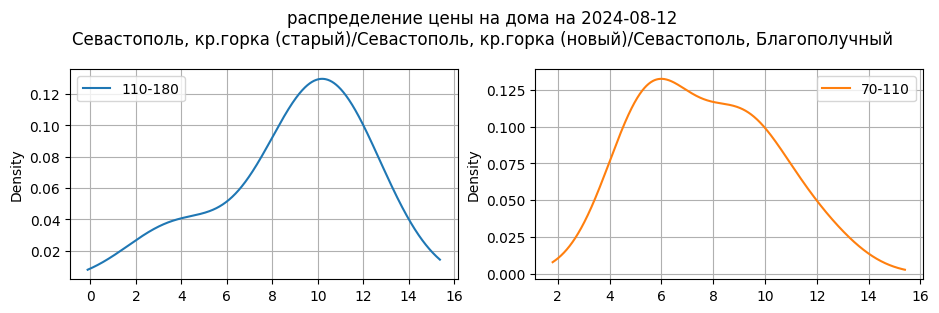

In [57]:
q_95 = gdf_last_local['priceM'].quantile(.95)

# fig, ax = plt.subplots() #figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .query('house_size_category in @sizes_')
    #.groupby(['house_size_category'],observed=True)
    .pivot(columns='house_size_category',values='priceM')
    #['priceM']
    #.count()
    .plot.kde(
        legend=True,
        #ax=ax,
        # title='/'.join(area_name), 
        title=f'распределение цены на дома на '+ str( dt_now )+ '\n'+'/'.join(area_name), 
        grid=True,
        subplots=True,
        layout=(2,2),
        figsize=(11,6),
        sharex=False
    )   
)
#fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
#fig.tight_layout()

----

In [58]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [59]:
stat = (
        gdf_local
        # .groupby(['house_size_category','month'],observed=True)
        .groupby(['house_size_category','week'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
        .dropna()
    )
display( stat )

count  mean  std   min    1%    5%  \
house_size_category week                                                        
30-50               2024-06-03/2024-06-09   3.00  5.90 0.09  5.85  5.85  5.85   
                    2024-06-10/2024-06-16   3.00  5.80 0.17  5.70  5.70  5.70   
                    2024-06-17/2024-06-23   3.00  5.80 0.17  5.70  5.70  5.70   
                    2024-06-24/2024-06-30   3.00  5.80 0.17  5.70  5.70  5.70   
                    2024-07-08/2024-07-14   3.00  5.82 0.16  5.70  5.70  5.71   
                    2024-07-15/2024-07-21   3.00  5.33 0.91  4.30  4.33  4.44   
                    2024-07-22/2024-07-28   2.00  5.00 0.99  4.30  4.31  4.37   
                    2024-07-29/2024-08-04   3.00  5.33 0.91  4.30  4.33  4.44   
                    2024-08-05/2024-08-11   2.00  4.30 0.00  4.30  4.30  4.30   
50-70               2024-06-03/2024-06-09   3.00  7.27 0.79  6.35  6.38  6.49   
                    2024-06-10/2024-06-16   4.00  8.02 2.07  6.35  6.37  6.45   
                    2024-06-17/2024-06-23   5.00  7.03 0.69  6.35  6.35  6.35   
                    2024-06-24/2024-06-30   4.00  7.20 0.66  6.35  6.37  6.45   
                    2024-07-08/2024-07-14   3.00  7.48 0.42  7.00  7.01  7.07   
                    2024-07-29/2024-08-04   2.00  6.55 1.48  5.50  5.52  5.61   
70-110              2024-06-03/2024-06-09  13.00  7.60 2.57  5.22  5.23  5.24   
                    2024-06-10/2024-06-16  14.00  7.74 2.52  5.22  5.23  5.24   
                    2024-06-17/2024-06-23  15.00  7.66 2.45  5.22  5.23  5.24   
                    2024-06-24/2024-06-30  14.00  7.55 2.51  5.22  5.23  5.24   
                    2024-07-08/2024-07-14  10.00  7.95 2.45  5.22  5.22  5.22   
                    2024-07-15/2024-07-21  10.00  6.65 1.88  5.22  5.22  5.22   
                    2024-07-22/2024-07-28  12.00  7.15 1.83  5.22  5.23  5.24   
                    2024-07-29/2024-08-04  13.00  7.20 1.93  5.22  5.23  5.24   
                    2024-08-05/2024-08-11   8.00  6.65 1.79  5.20  5.20  5.22   
                    2024-08-12/2024-08-18  10.00  8.38 3.14  5.20  5.22  5.29   
110-180             2024-06-03/2024-06-09   9.00 10.22 2.81  6.50  6.50  6.50   
                    2024-06-10/2024-06-16  15.00 10.58 2.66  6.50  6.50  6.50   
                    2024-06-17/2024-06-23  14.00  9.69 2.83  4.25  4.54  5.71   
                    2024-06-24/2024-06-30   9.00  8.92 2.92  4.25  4.43  5.15   
                    2024-07-08/2024-07-14  12.00  9.81 2.91  3.80  4.10  5.29   
                    2024-07-15/2024-07-21   7.00 10.07 3.64  3.75  4.06  5.29   
                    2024-07-22/2024-07-28   6.00  8.56 2.52  3.75  3.98  4.89   
                    2024-07-29/2024-08-04   8.00 10.42 1.94  8.30  8.34  8.51   
                    2024-08-05/2024-08-11   9.00 10.83 3.41  3.75  4.16  5.81   
                    2024-08-12/2024-08-18   7.00 10.56 3.75  3.75  4.06  5.29   
180-300             2024-06-03/2024-06-09   2.00  8.25 2.47  6.50  6.54  6.67   
                    2024-06-10/2024-06-16   4.00 10.50 2.97  6.50  6.61  7.03   
                    2024-06-17/2024-06-23   4.00 10.50 2.97  6.50  6.61  7.03   
                    2024-06-24/2024-06-30   2.00  9.62 4.42  6.50  6.56  6.81   
                    2024-07-08/2024-07-14   4.00 10.50 2.97  6.50  6.61  7.03   
                    2024-07-15/2024-07-21   4.00 10.50 2.97  6.50  6.61  7.03   
                    2024-07-22/2024-07-28   2.00 11.38 1.94 10.00 10.03 10.14   
                    2024-07-29/2024-08-04   2.00 12.75 0.00 12.75 12.75 12.75   
                    2024-08-05/2024-08-11   2.00 12.75 0.00 12.75 12.75 12.75   
                    2024-08-12/2024-08-18   2.00 11.38 1.94 10.00 10.03 10.14   

                                            10%   25%   50%   75%   90%   95%  \
house_size_category week                                                        
30-50               2024-06-03/2024-06-09  5.85  5.85  5.85  5.92  5.97  

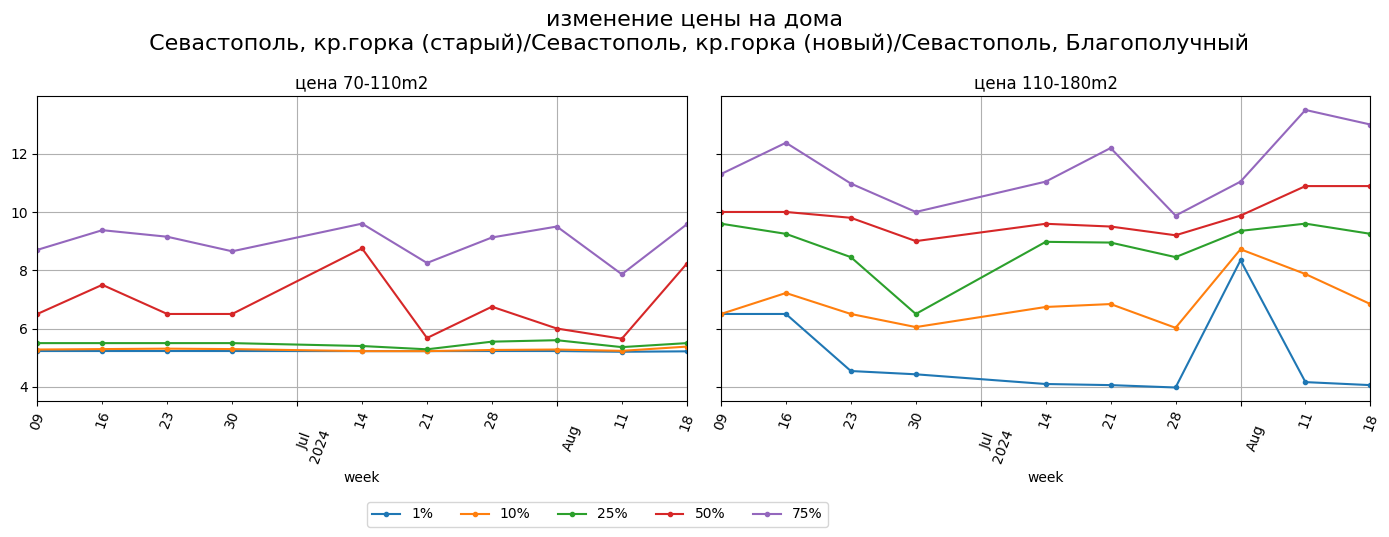

In [60]:
fig, ax = plt.subplots(1,len(sizes_),figsize=(14,5), sharey=True )

for i,s in enumerate(sizes_): 
    stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на дома\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

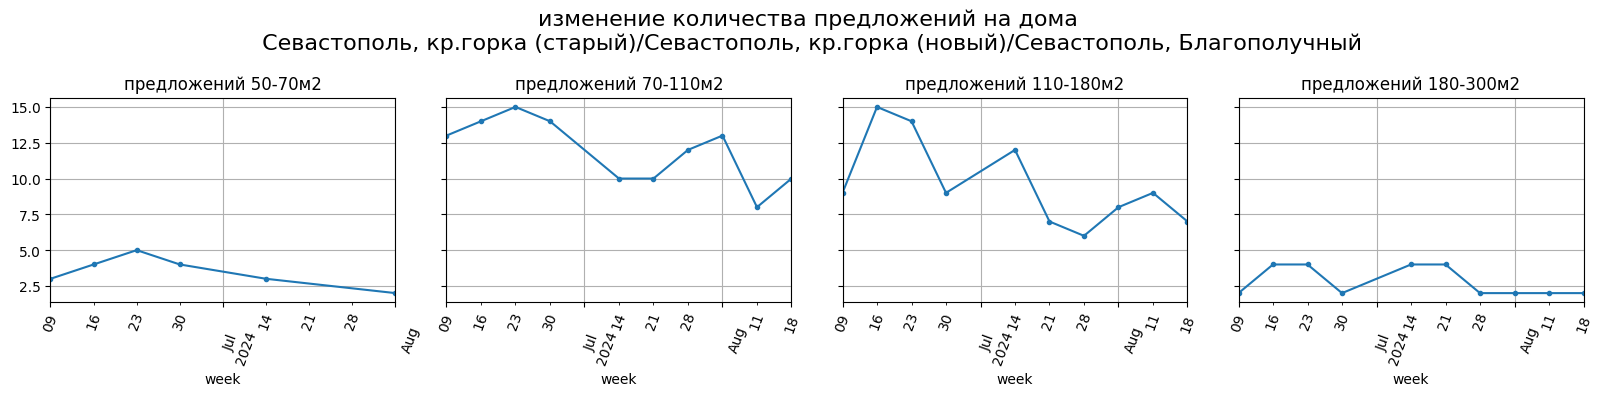

In [61]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение количества предложений на дома\n {'/'.join(area_name)}', fontsize=16)

#fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()